In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

In [2]:
import kmod
import kmod.glo as glo
import kmod.plot as plot
import kmod.kernel as kernel
from kmod import util
import kmod.ex.exutil as exutil
from kmod import data

import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy.stats as stats
import torch
import torch.autograd
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


from torch import optim
from torch import nn
import kmod.gan_ume_opt as ganopt
from kmod.gan_ume_opt import ume_power_criterion

In [3]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
# set this to False to avoid using a GPU
use_cuda = True and torch.cuda.is_available()
# load option depends on whether GPU is used
load_options = {} if use_cuda else {'map_location': lambda storage, loc: storage} 
device = torch.device("cuda" if use_cuda else "cpu")
default_type = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
torch.set_default_tensor_type(torch.cuda.FloatTensor if use_cuda else torch.FloatTensor)

In [5]:
seed = 13
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Load feature extractor

In [6]:
# load a model from the shared folder
shared_resource_path = glo.shared_resource_folder()
model_folder = glo.shared_resource_folder('prob_models', 'mnist_cnn')
epochs = 20
seed = 1
model_fname = 'mnist_cnn_ep{}_s{}.pt'.format(epochs, seed)
model_fpath = os.path.join(model_folder, model_fname)

print('Shared resource path at: {}'.format(shared_resource_path))
print('Model folder: {}'.format(model_folder))
print('Model file: ', model_fname)

Shared resource path at: /nfs/data3/heishiro/Gdrive/kmod_share/
Model folder: /nfs/data3/heishiro/Gdrive/kmod_share/prob_models/mnist_cnn
Model file:  mnist_cnn_ep20_s1.pt


In [7]:
from kmod.mnist.classify import MnistClassifier
classifier = MnistClassifier.load(model_fpath, **load_options)
# evaluation mode
classifier = classifier.eval().to(device)
# classifier is a torch.nn.Module
display(classifier)

MnistClassifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [8]:
def extractor(imgs):
    """
    Feature extractor
    """
    self = classifier
    x = imgs
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = x.view(-1, 320)
    return x

def extractor_cls(imgs):
    self = classifier
    x = imgs
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    return x

## Load models and generate samples

In [9]:
# these lines are necessary for loading DCGAN
from kmod.mnist.dcgan import Generator
from kmod.mnist.dcgan import DCGAN

In [10]:
model_type_p = 'lsgan'
epoch = 30
gen_p = exutil.load_mnist_gen(model_type_p, epoch, default_type, **load_options)
model_name_p = '{}_{}'.format(model_type_p, epoch)

Loading  lsgan
Shared resource path at: /nfs/data3/heishiro/Gdrive/kmod_share/
Model folder: /nfs/data3/heishiro/Gdrive/kmod_share/prob_models/mnist_lsgan/30
Model file:  LSGAN_G.pkl


<Figure size 1440x360 with 0 Axes>

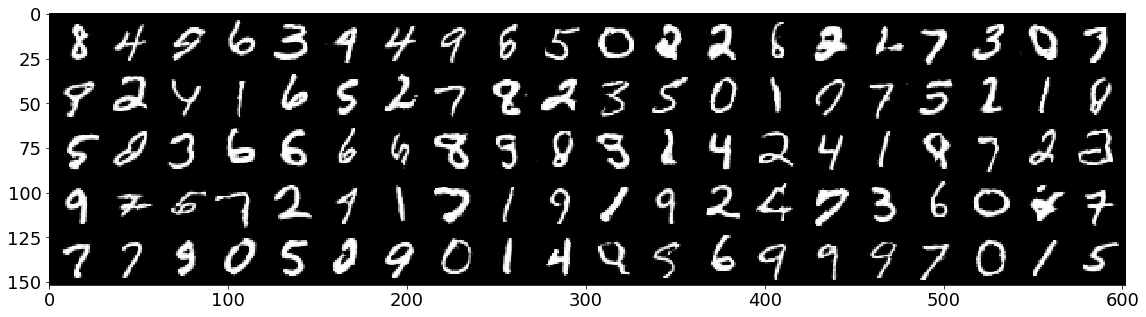

In [11]:
import kmod.plot as plot

# generate images and show
n_gen = 20*5
gen_imgs = gen_p.sample(n_gen)

plt.figure(figsize=(20, 5))
plot.show_torch_imgs(gen_imgs, nrow=20, figsize=(20, 5), normalize=True)

In [12]:
model_type_q = 'dcgan'
epoch = 50
gen_q = exutil.load_mnist_gen(model_type_q, epoch, default_type, **load_options)
model_name_q = '{}_{}'.format(model_type_q, epoch)
print(gen_q.sample_noise(100))

Loading  dcgan
Shared resource path at: /nfs/data3/heishiro/Gdrive/kmod_share/
Model folder: /nfs/data3/heishiro/Gdrive/kmod_share/prob_models/mnist_dcgan
Model file:  mnist_dcgan_ep50_bs64.pt
tensor([[-0.7124,  0.7538, -0.0445,  ..., -0.6511, -1.1205, -0.3466],
        [-0.9113, -0.7461, -0.7710,  ...,  0.9552,  0.0200,  0.8628],
        [ 0.7435, -0.6626, -0.3052,  ..., -0.8447,  1.1723,  1.1491],
        ...,
        [ 0.4583,  0.7696, -1.4992,  ..., -0.0978,  0.0442,  0.5756],
        [-1.8642, -0.3849,  0.7637,  ..., -0.2710, -1.2061, -0.9775],
        [ 1.1764, -1.6492,  0.1005,  ..., -0.7550,  1.6403,  1.4504]])


/nfs/nhome/live/heishirok/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


<Figure size 1440x360 with 0 Axes>

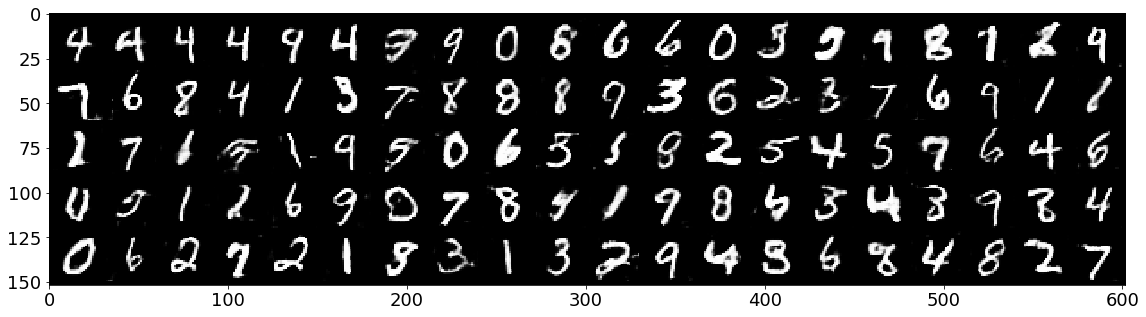

In [13]:
import kmod.plot as plot

# generate images and show
n_gen = 20*5
gen_imgs = gen_q.sample(n_gen)

plt.figure(figsize=(20, 5))
plot.show_torch_imgs(gen_imgs, nrow=20, figsize=(20, 5), normalize=True)

## Load MNIST Data

In [14]:
# load MNIST data
mnist_folder = glo.data_file('mnist')
mnist_dataset = torchvision.datasets.MNIST(mnist_folder, train=False, 
                        transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))

In [15]:
num_sample = 2000
classes = 10
n_sample_per_class = num_sample // classes
len_data = len(mnist_dataset)
input_Z = []
mnist_Y = torch.stack([mnist_dataset[i][1] for i in range(len_data)])
mnist_X = torch.stack([mnist_dataset[i][0] for i in range(len_data)])
for i in range(classes):
    idx_Y = mnist_Y[mnist_Y==i]
    idx = util.subsample_ind(len(idx_Y), n_sample_per_class, seed=13)
    input_Z.append(mnist_X[idx_Y][idx])
#input_Z = [mnist_dataset[i][0] for i in range(num_sample)]
input_Z = torch.cat(input_Z).to(device)


## Sample from generators

In [16]:
def norm(x, loc, scale):
    return (x - loc) / scale


def mnist_norm(x):
    return norm(x, 0.1307, 0.3081)

In [17]:
def trans_gan(x):
    y = norm(x, -1.0, 2.0)
    return mnist_norm(y)


def trans_vae(x):
    return mnist_norm(x).view(-1, 1, 28, 28)

def get_trans(model_type):
    name = model_type.lower()
    if name not in exutil.mnist_model_names:
        raise ValueError('Model name has be one of '
                          '{} and was'.format(key_list, name))
    print('Model: {}'.format(name))
    if 'gan' in name:
        return trans_gan
    elif name == 'vae':
        return mnist_norm

## Optimization settings

In [18]:
J = 30

gen_p_forward = gen_p.module.forward
gen_q_forward = gen_q.module.forward
trans_p = get_trans(model_type_p)
trans_q = get_trans(model_type_q)
#featurizer = extractor_cls
featurizer = classifier

reg = 1e-4 
lam_z = 1e-5
lam_gw = 1e-4
gwidth_lb = None
gwidth_ub = None
Zp_lb= -(4.**2)
Zp_ub= 1.**2
Zq_lb= -(4.**2)
Zq_ub= 1.**2

X = featurizer(trans_p(gen_p.sample(num_sample)))
Y = featurizer(trans_q(gen_q.sample(num_sample)))
Z = featurizer(input_Z)

XYZ = np.vstack((X.cpu().data.numpy(), Y.cpu().data.numpy(), Z.cpu().data.numpy()))
med = util.meddistance(XYZ, subsample=1000)
gwidth0 = med
Zp0 = torch.rand([J, gen_p.in_out_shapes[0]]) - 0.5
Zq0 = torch.rand([J, gen_q.in_out_shapes[0]]) - 0.5 

Model: lsgan
Model: dcgan


/nfs/nhome/live/heishirok/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [19]:
def reg_z(Zp, Zq):
    eps = 0.  # 1e-10
    log_bar_p = (torch.sum(torch.log(Zp_ub-Zp**2+eps)) 
                 if Zp_ub is not None else 0)
    # log_bar_p = (log_bar_p + torch.sum(torch.log(-Zp_lb+Zp+eps))
                 # if Zp_lb is not None else log_bar_p)
    log_bar_q = (torch.sum(torch.log(Zq_ub-Zq**2+eps)) 
                 if Zq_ub is not None else 0)
    #log_bar_q = (log_bar_q + torch.sum(torch.log(-Zq_lb+Zq+eps))
                 #if Zq_lb is not None else log_bar_q)
    return log_bar_p + log_bar_q

def reg_gw2(gwidth2):
    eps = 0.  # 1e-6
    log_bar_gwidth = (torch.log(gwidth_ub-gwidth2+eps)
                      if gwidth_ub is not None else 0)
    log_bar_gwidth = (log_bar_gwidth + (torch.log(-max(gwidth_lb, 0)+gwidth2+eps))
                      if gwidth_lb is not None else log_bar_gwidth)

    return log_bar_gwidth

## Optimization

In [20]:
dtype = torch.float
gwidth2 = torch.tensor(gwidth0**2, requires_grad=True, device=device)
k = kernel.PTKGauss(gwidth2)
Zp = torch.tensor(Zp0, requires_grad=True, device=device,
        dtype=dtype)
Zq = torch.tensor(Zq0, requires_grad=True, device=device,
        dtype=dtype)

X = torch.tensor(X, requires_grad=False, 
                 device=device, dtype=dtype)
Y = torch.tensor(Y, requires_grad=False,
                 device=device, dtype=dtype)
Z = torch.tensor(Z, requires_grad=False,
                 device=device, dtype=dtype)

# optimizer = optim.LBFGS([gwidth2, Zp, Zq], lr=1e-3, max_iter=20)
# optimizer = optim.SGD([gwidth2, Zp, Zq], lr=1e-3, momentum=0.9, nesterov=True)
optimizer = optim.Adam([k.sigma2, Zp, Zq], lr=1e-3)
# transform = nn.Upsample((model_input_size, model_input_size), mode='bilinear')

num_steps = 500
log_inter = 10

run = [0]
while run[0] <= num_steps:
    
    def closure():
        optimizer.zero_grad()
        im_p = gen_p_forward(Zp)
        im_q = gen_q_forward(Zq)
        Vp = featurizer(trans_p(im_p)) if trans_p is not None else featurizer(im_p)
        Vq = featurizer(trans_q(im_q)) if trans_q is not None else featurizer(im_q)
        V = torch.cat([Vp, Vq], dim=0)
        #power = ume_power_criterion(X, Y, Z, Vp, Vq, k, reg)
        power = ume_power_criterion(X, Y, Z, V, V, k, reg)
        obj = -power  - lam_z*reg_z(Zp, Zq) - lam_gw*reg_gw2(k.sigma2)
        obj.backward(retain_graph=True)
        run[0] += 1
        if run[0] % log_inter == 0:
            print('run {}'.format(run))
            print(obj, power)
        return obj
    optimizer.step(closure)

/nfs/nhome/live/heishirok/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


run [10]
tensor(-0.0032, grad_fn=<SubBackward>) tensor(0.0077, grad_fn=<DivBackward1>)
run [20]
tensor(-0.0111, grad_fn=<SubBackward>) tensor(0.0157, grad_fn=<DivBackward1>)
run [30]
tensor(-0.0163, grad_fn=<SubBackward>) tensor(0.0209, grad_fn=<DivBackward1>)
run [40]
tensor(-0.0202, grad_fn=<SubBackward>) tensor(0.0247, grad_fn=<DivBackward1>)
run [50]
tensor(-0.0231, grad_fn=<SubBackward>) tensor(0.0277, grad_fn=<DivBackward1>)
run [60]
tensor(-0.0252, grad_fn=<SubBackward>) tensor(0.0298, grad_fn=<DivBackward1>)
run [70]
tensor(-0.0268, grad_fn=<SubBackward>) tensor(0.0313, grad_fn=<DivBackward1>)
run [80]
tensor(-0.0281, grad_fn=<SubBackward>) tensor(0.0327, grad_fn=<DivBackward1>)
run [90]
tensor(-0.0295, grad_fn=<SubBackward>) tensor(0.0341, grad_fn=<DivBackward1>)
run [100]
tensor(-0.0309, grad_fn=<SubBackward>) tensor(0.0354, grad_fn=<DivBackward1>)
run [110]
tensor(-0.0325, grad_fn=<SubBackward>) tensor(0.0371, grad_fn=<DivBackward1>)
run [120]
tensor(-0.0340, grad_fn=<SubBac

In [21]:
gen_imgs = gen_p_forward(Zp)
Vp = featurizer(trans_p(gen_imgs))

<Figure size 576x360 with 0 Axes>

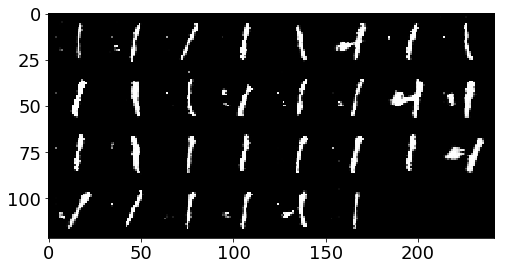

In [22]:
plt.figure(figsize=(8, 5))
plot.show_torch_imgs(gen_imgs.detach(), nrow=8, figsize=(8, 5), normalize=True)

/nfs/nhome/live/heishirok/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


<Figure size 576x360 with 0 Axes>

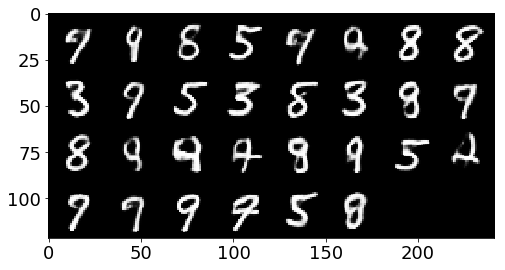

In [23]:
#gen_imgs = vae.decode(Zq).detach().view(-1, 1, 28, 28)
gen_imgs = gen_q_forward(Zq).detach()
Vq = featurizer(trans_q(gen_imgs))
plt.figure(figsize=(8, 5))
plot.show_torch_imgs(gen_imgs, nrow=8, figsize=(8, 5), normalize=True)

In [24]:
print(Zp.max())
print(Zp.min())

tensor(0.7074, grad_fn=<MaxBackward1>)
tensor(-0.6912, grad_fn=<MinBackward1>)


In [25]:
print(Zq.max())
print(Zq.min())

tensor(0.8272, grad_fn=<MaxBackward1>)
tensor(-0.7485, grad_fn=<MinBackward1>)


In [26]:
print(k.sigma2, gwidth0**2)

tensor(1540.8673, requires_grad=True) 1541.4280428342172


## Check the power criterion value at each location

In [27]:
from kmod import mctest 
from kgof import kernel as kgof_kernel
V = torch.cat([Vp, Vq]).cpu().data.numpy()
for j in range(J):
    V = Vq[j].cpu().data.numpy().reshape([1, -1])
    kg = kgof_kernel.KGauss(gwidth2.item())
    datap = kmod.data.Data(X.cpu().data.numpy())
    dataq = kmod.data.Data(Y.cpu().data.numpy())
    datar = kmod.data.Data(Z.cpu().data.numpy())
    sc_ume = mctest.SC_UME(datap, dataq, kg, kg, V, V)
    print(j, sc_ume.compute_stat(datar))

0 0.06324109230321805
1 0.045826333711266896
2 0.006454279477672477
3 0.0805132098222113
4 0.058717486468393504
5 0.0399864797245578
6 0.020898806686477065
7 0.02929417995634392
8 0.0455192529618204
9 0.039435568841881805
10 0.08223833362584287
11 0.053250416931986184
12 0.04242491392369778
13 0.05194812508646634
14 0.010501428179624942
15 0.040200029585656216
16 0.020256104253031513
17 0.03787073462652165
18 0.04829034771684054
19 0.05876632257602835
20 0.009312343142981561
21 0.03796380696365895
22 0.08125310025991499
23 0.047281220761168474
24 0.031799050944857535
25 0.03713297095686559
26 -0.03433975577957107
27 0.05266810494077701
28 0.08096916037886535
29 0.010387866587760341


## Discrete optimization

In [28]:
def slice_array(arr, sizes):
    if not sizes or sum(sizes) == 0 or len(sizes) == 0:
        raise ValueError('sizes cannot be empty. Was {}'.format(sizes))
    sub_arrs = []
    idx = 0
    for i in range(0, len(sizes)):
        sub_arrs.append(arr[idx: idx+sizes[i]])
        idx += sizes[i]
    return sub_arrs

## Optimization settings

In [47]:
J = 30

num_classes = 10
trans_p = get_trans(model_type_p)
trans_q = get_trans(model_type_q)
featurizer = extractor_cls
#featurizer = classifier

reg = 1e-4

Model: lsgan
Model: dcgan


In [48]:
#Y = featurizer(mnist_norm(vae_sample(vae, num_sample)))
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

V_pool = []
Z_list = []
for j in range(num_classes):
    idx = (mnist_Y == j)
    rand_idx = util.subsample_ind(len(mnist_Y[idx]), len(mnist_Y[idx]), seed=seed)
    Z, V = slice_array(mnist_X[idx][rand_idx], [n_sample_per_class, J]) 
    Z_list.append(Z)
    V_pool.append(V)

X = featurizer(trans_p(gen_p.sample(num_sample)))
Y = featurizer(trans_q(gen_q.sample(num_sample)))
Z = torch.cat(Z_list).to(device)
Z = featurizer(Z)

X = X.cpu().data.numpy()
Y = Y.cpu().data.numpy()
Z = Z.cpu().data.numpy()

XYZ = np.vstack((X, Y, Z))
med = util.meddistance(XYZ, subsample=1000)
k = kernel.KGauss(med**2)

V = torch.cat(V_pool)
fV = featurizer(V.to(device)).cpu().data.numpy()

/nfs/nhome/live/heishirok/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Took 23.484375953674316 secs


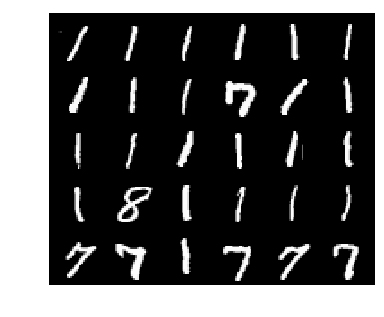

In [49]:
with util.ContextTimer() as t:
    opt_idx = ganopt.opt_greedy_3sample_criterion(data.Data(X), data.Data(Y), data.Data(Z), fV, k, J, maximize=True)
print('Took {} secs'.format(t.secs))
opt_locs = V[opt_idx]
plot.show_torch_imgs(opt_locs, nrow=6, figsize=(6, 5), normalize=True)

Took 23.471575260162354 secs


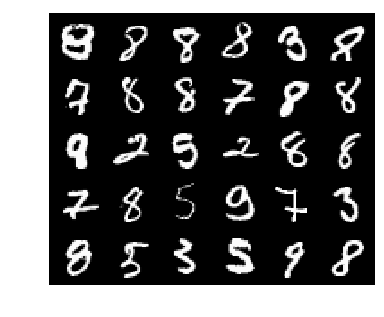

In [50]:
with util.ContextTimer() as t:
    opt_idx = ganopt.opt_greedy_3sample_criterion(data.Data(X), data.Data(Y), data.Data(Z), fV, k, J, maximize=False)
print('Took {} secs'.format(t.secs))
opt_locs = V[opt_idx]
plot.show_torch_imgs(opt_locs, nrow=6, figsize=(6, 5), normalize=True)